In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread("./all data/cow and boy.png")

(np.float64(-0.5), np.float64(2815.5), np.float64(1535.5), np.float64(-0.5))

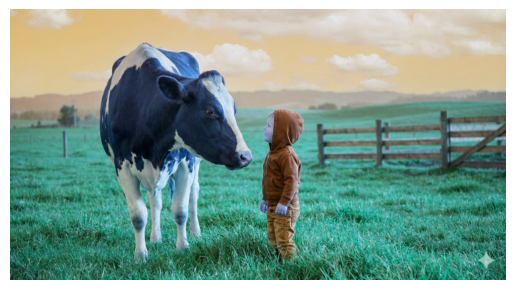

In [13]:
plt.imshow(image) ## cv2 can automatically convert rgb to bgr 
plt.axis("off")

In [7]:
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

(np.float64(-0.5), np.float64(2815.5), np.float64(1535.5), np.float64(-0.5))

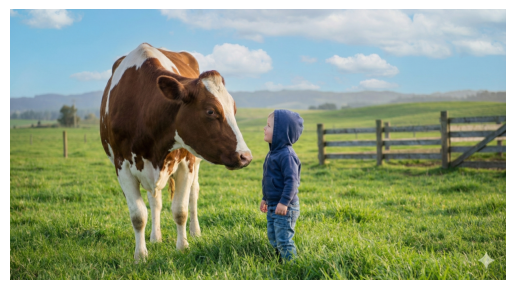

In [14]:
plt.imshow(rgb_image)
plt.axis("off")

(np.float64(-0.5), np.float64(2815.5), np.float64(1535.5), np.float64(-0.5))

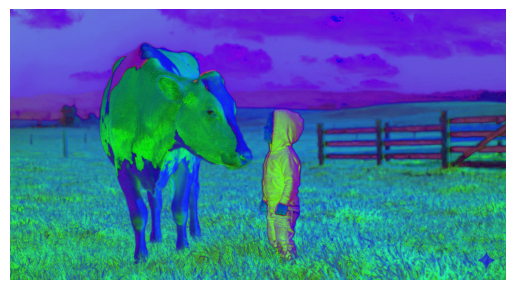

In [15]:
plt.imshow(hsv_image)
plt.axis("off")

In [17]:
##  Define Color Ranges (Cow + Boy)
# Brown cow range
lower_brown = np.array([10, 50, 50])
upper_brown = np.array([25, 255, 255])

# Blue jacket range
lower_blue = np.array([90, 50, 50])
upper_blue = np.array([130, 255, 255])

# White cow spots
lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])

In [18]:
mask = cv2.inRange(hsv_image,lower_brown,upper_brown,lower_blue,upper_blue,lower_white,upper_white)

error: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'inRange'
> Overload resolution failed:
>  - inRange() takes at most 4 arguments (7 given)
>  - inRange() takes at most 4 arguments (7 given)


####  Why This Works
	•	cv2.inRange() → detects one color range
	•	Multiple objects → multiple masks
	•	NumPy | operator → merges all detections into single foreground mask

⸻

🧠 One-Line Concept (Interview Ready)

cv2.inRange works on one color range at a time, so multiple object colors must be detected using separate masks and then combined.


In [19]:
mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
mask_blue  = cv2.inRange(hsv_image, lower_blue, upper_blue)
mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

mask = mask_brown | mask_blue | mask_white

(np.float64(-0.5), np.float64(2815.5), np.float64(1535.5), np.float64(-0.5))

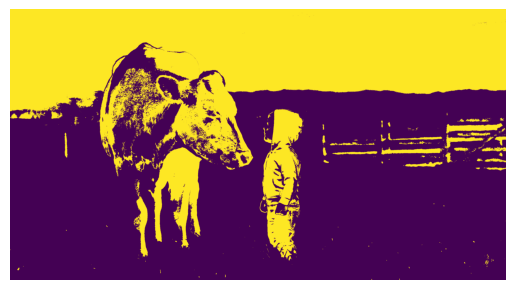

In [21]:
plt.imshow(mask)
plt.axis("off")

❌ Why your current mask fails

From your mask image:
	•	Grass, sky, fence → also selected
	•	That means:
	•	Hue range too wide
	•	Low saturation / brightness not filtered
	•	White range is masking background

In short:

✅ You detected “almost everything that is not black”

✅ Correct Strategy to Target ONLY Cow + Boy

We’ll improve segmentation using 3 rules:
	1.	Remove background using Saturation + Value
	2.	Use tighter HSV ranges
	3.	Post-process mask properly

STEP 1: Filter OUT background first (IMPORTANT)

Grass & sky have high brightness but low relevance.
Cow + boy have moderate saturation and value.

In [ ]:
##  Basic foreground filter
h, s, v = cv2.split(hsv_image)

# Keep only moderately saturated & bright pixels
sv_mask = cv2.inRange(s, 40, 255) & cv2.inRange(v, 50, 255)

## This alone removes sky & many background areas.

In [23]:
## STEP 2: Tighter Color Ranges (REALISTIC)
# Brown Cow (tighter)
lower_brown = np.array([12, 80, 50])
upper_brown = np.array([25, 200, 200])

## Blue Jacket (Boy)
lower_blue = np.array([95, 80, 50])
upper_blue = np.array([125, 255, 200])

## White Cow Spots (restrict brightness)
lower_white = np.array([0, 0, 180])
upper_white = np.array([180, 40, 255])

STEP 3: Correct Mask Creation ✅✅

In [24]:
mask_brown = cv2.inRange(hsv_image, lower_brown, upper_brown)
mask_blue  = cv2.inRange(hsv_image, lower_blue, upper_blue)
mask_white = cv2.inRange(hsv_image, lower_white, upper_white)

# Combine object masks
object_mask = mask_brown | mask_blue | mask_white

# Apply saturation-value filter
final_mask = cv2.bitwise_and(object_mask, sv_mask)

STEP 4: Clean Mask (VERY IMPORTANT)

In [25]:
kernel = np.ones((7,7), np.uint8)

final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel)
final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, kernel)

STEP 5: View RESULT (this time it will work)

(np.float64(-0.5), np.float64(2815.5), np.float64(1535.5), np.float64(-0.5))

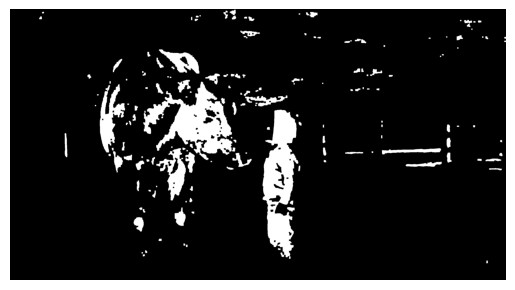

In [26]:
plt.imshow(final_mask, cmap='gray')
plt.axis('off')

In [29]:
black_hsv = np.uint8([[[120, 255, 0]]])
blac_bgr = cv2.cvtColor(black_hsv, cv2.COLOR_HSV2BGR)[0][0]

In [ ]:
image_result = image.copy()